# Capstone 2: West Nile Virus Prediction

In [151]:
#Importing Relevant Packages
import pandas.core.algorithms as algos
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Initial Data Cleaning

In [73]:
#importing CSV files to dataframes
train = pd.read_csv("train.csv", parse_dates=True)
weather = pd.read_csv("weather.csv", parse_dates=True)

In [74]:
#Checking shape of each DF
train.shape

(10506, 12)

In [75]:
weather.shape

(2944, 22)

In [76]:
#Checking first 10 rows of train
train.head(10)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
1,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.954690,-87.800991,9,1,0
2,2007-05-29,"6200 North Mandell Avenue, Chicago, IL 60646, USA",CULEX RESTUANS,62,N MANDELL AVE,T007,"6200 N MANDELL AVE, Chicago, IL",41.994991,-87.769279,9,1,0
3,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX PIPIENS/RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,1,0
4,2007-05-29,"7900 West Foster Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,79,W FOSTER AVE,T015,"7900 W FOSTER AVE, Chicago, IL",41.974089,-87.824812,8,4,0
5,2007-05-29,"1500 West Webster Avenue, Chicago, IL 60614, USA",CULEX RESTUANS,15,W WEBSTER AVE,T045,"1500 W WEBSTER AVE, Chicago, IL",41.921600,-87.666455,8,2,0
6,2007-05-29,"2500 West Grand Avenue, Chicago, IL 60654, USA",CULEX RESTUANS,25,W GRAND AVE,T046,"2500 W GRAND AVE, Chicago, IL",41.891118,-87.654491,8,1,0
7,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX PIPIENS/RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,1,0
8,2007-05-29,"1100 Roosevelt Road, Chicago, IL 60608, USA",CULEX RESTUANS,11,W ROOSEVELT,T048,"1100 W ROOSEVELT, Chicago, IL",41.867108,-87.654224,8,2,0
9,2007-05-29,"1100 West Chicago Avenue, Chicago, IL 60642, USA",CULEX RESTUANS,11,W CHICAGO,T049,"1100 W CHICAGO, Chicago, IL",41.896282,-87.655232,8,1,0


In [77]:
#Checking basic train stats
train.describe()

,Block,Latitude,Longitude,AddressAccuracy,NumMosquitos,WnvPresent
count,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000,10506.000000
mean,35.687797,41.841139,-87.699908,7.819532,12.853512,0.052446
std,24.339468,0.112742,0.096514,1.452921,16.133816,0.222936
min,10.000000,41.644612,-87.930995,3.000000,1.000000,0.000000
25%,12.000000,41.732984,-87.760070,8.000000,2.000000,0.000000
50%,33.000000,41.846283,-87.694991,8.000000,5.000000,0.000000
75%,52.000000,41.954690,-87.627796,9.000000,17.000000,0.000000
max,98.000000,42.017430,-87.531635,9.000000,50.000000,1.000000


In [78]:
#repeating for Weather
weather.head(10)

,Station,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,...,CodeSum,Depth,Water1,SnowFall,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,1,2007-05-01,83,50,67,14,51,56,0,2,...,,0,M,0.0,0.00,29.10,29.82,1.7,27,9.2
1,2,2007-05-01,84,52,68,M,51,57,0,3,...,,M,M,M,0.00,29.18,29.82,2.7,25,9.6
2,1,2007-05-02,59,42,51,-3,42,47,14,0,...,BR,0,M,0.0,0.00,29.38,30.09,13.0,4,13.4
3,2,2007-05-02,60,43,52,M,42,47,13,0,...,BR HZ,M,M,M,0.00,29.44,30.08,13.3,2,13.4
4,1,2007-05-03,66,46,56,2,40,48,9,0,...,,0,M,0.0,0.00,29.39,30.12,11.7,7,11.9
5,2,2007-05-03,67,48,58,M,40,50,7,0,...,HZ,M,M,M,0.00,29.46,30.12,12.9,6,13.2
6,1,2007-05-04,66,49,58,4,41,50,7,0,...,RA,0,M,0.0,T,29.31,30.05,10.4,8,10.8
7,2,2007-05-04,78,51,M,M,42,50,M,M,...,,M,M,M,0.00,29.36,30.04,10.1,7,10.4
8,1,2007-05-05,66,53,60,5,38,49,5,0,...,,0,M,0.0,T,29.40,30.10,11.7,7,12.0
9,2,2007-05-05,66,54,60,M,39,50,5,0,...,,M,M,M,T,29.46,30.09,11.2,7,11.5


In [79]:
weather.describe()

,Station,Tmax,Tmin,DewPoint,ResultSpeed,ResultDir
count,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000,2944.000000
mean,1.500000,76.166101,57.810462,53.457880,6.960666,17.494905
std,0.500085,11.461970,10.381939,10.675181,3.587527,10.063609
min,1.000000,41.000000,29.000000,22.000000,0.100000,1.000000
25%,1.000000,69.000000,50.000000,46.000000,4.300000,7.000000
50%,1.500000,78.000000,59.000000,54.000000,6.400000,19.000000
75%,2.000000,85.000000,66.000000,62.000000,9.200000,25.000000
max,2.000000,104.000000,83.000000,75.000000,24.100000,36.000000


In [80]:
#custom functions to create Average Temperature and Decadent normal (used to calculate range later )
def fill_Tavg(x1,x2,x3):
    if pd.isnull(x3):
        x3=np.ceil((x1+x2)/2)
        return x3
    else:
        return x3
def calc_decadent_normal(x1,x2):
    if pd.isnull(x2):
        return np.nan
    else:
        return int(x1)-int(x2)
    

In [81]:
#filling NAs and dropping unneeded columns. FFill method used for missing values as asssociated columns have very similar values
weather=weather.replace('-', np.nan)
weather=weather.replace('M', np.nan)
median_speed = weather['AvgSpeed'].median()
weather['AvgSpeed'] = weather['AvgSpeed'].fillna(value=median_speed)

col = ['Sunrise', 'WetBulb', 'Sunset', 'Heat', 'Cool','SeaLevel','StnPressure']

for x in col: 
    weather[x] = weather[x].fillna(method='ffill')

weather['PrecipTotal'] = weather['PrecipTotal'].apply(lambda x: 0.00 if str(x).strip()=='T' or pd.isnull(x) else x)
weather['PrecipBool'] = weather['PrecipTotal'].apply(lambda x: 'N' if x=='0.00' else 'Y')
weather['Tavg']=weather.apply(lambda x: fill_Tavg(x['Tmax'], x['Tmin'], x['Tavg']), axis=1)
weather['decadent_normal']=weather.apply(lambda x: calc_decadent_normal(x['Tavg'], x['Depart']), axis=1)
weather['decadent_normal']=weather['decadent_normal'].fillna(method='ffill')
weather['Depart']=weather.apply(lambda x: int(x['Tavg'])-int(x['decadent_normal']), axis=1)

weather=weather.drop(['decadent_normal'], axis=1)
weather=weather.drop(['Water1','Depth', 'SnowFall', 'CodeSum'], axis=1)
train = train.drop(['Address', 'AddressNumberAndStreet'], axis = 1)


In [82]:
#Checking for null values
weather.isnull().sum()

Station        0
Date           0
Tmax           0
Tmin           0
Tavg           0
Depart         0
DewPoint       0
WetBulb        0
Heat           0
Cool           0
Sunrise        0
Sunset         0
PrecipTotal    0
StnPressure    0
SeaLevel       0
ResultSpeed    0
ResultDir      0
AvgSpeed       0
PrecipBool     0
dtype: int64

In [83]:
#Checking data types amongst both dfs
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             10506 non-null  object 
 1   Species          10506 non-null  object 
 2   Block            10506 non-null  int64  
 3   Street           10506 non-null  object 
 4   Trap             10506 non-null  object 
 5   Latitude         10506 non-null  float64
 6   Longitude        10506 non-null  float64
 7   AddressAccuracy  10506 non-null  int64  
 8   NumMosquitos     10506 non-null  int64  
 9   WnvPresent       10506 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 820.9+ KB


In [84]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944 entries, 0 to 2943
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Station      2944 non-null   int64  
 1   Date         2944 non-null   object 
 2   Tmax         2944 non-null   int64  
 3   Tmin         2944 non-null   int64  
 4   Tavg         2944 non-null   object 
 5   Depart       2944 non-null   int64  
 6   DewPoint     2944 non-null   int64  
 7   WetBulb      2944 non-null   object 
 8   Heat         2944 non-null   object 
 9   Cool         2944 non-null   object 
 10  Sunrise      2944 non-null   object 
 11  Sunset       2944 non-null   object 
 12  PrecipTotal  2944 non-null   object 
 13  StnPressure  2944 non-null   object 
 14  SeaLevel     2944 non-null   object 
 15  ResultSpeed  2944 non-null   float64
 16  ResultDir    2944 non-null   int64  
 17  AvgSpeed     2944 non-null   object 
 18  PrecipBool   2944 non-null   object 
dtypes: flo

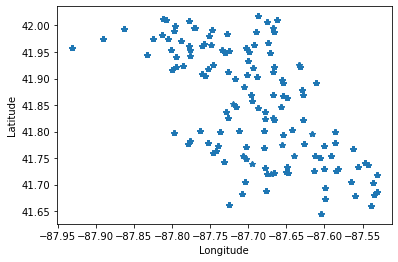

In [85]:
#Checking spread of lat/long values. Notice that only a couple of very small clusters exist.
plt.plot(train.Longitude,train.Latitude, '*')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

/Users/evanmeeks/opt/anaconda3/envs/sklearn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/evanmeeks/opt/anaconda3/envs/sklearn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


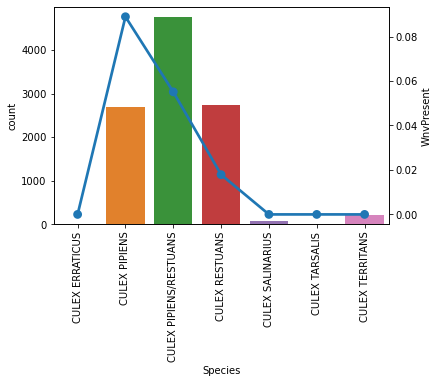

In [86]:
#Determining which species has the highest rate of the virus. One trap referred to two species, 
#and must have contained both in its samples.
#Out of 6 species, only two contained WNV. 
species = pd.crosstab(train['Species'],train['WnvPresent'],normalize='index')
species.reset_index(drop=True)
species.columns = ['WnvAbsent','WnvPresent']

fig,ax = plt.subplots(1,1)
g = sns.countplot(train['Species'], ax=ax, order = list(species.index))
ax.tick_params(axis='x',rotation=90)
g2 = g.twinx()
sns.pointplot(species.index, species['WnvPresent'], ax=g2, order = list(species.index))
plt.show()

In [87]:
#Checking the number of mosqitos of each species
Species_mosquito_no=train.groupby('Species')['NumMosquitos'].sum().sort_values(ascending=False)
Species_mosquito_no

Species
CULEX PIPIENS/RESTUANS    66268
CULEX PIPIENS             44671
CULEX RESTUANS            23431
CULEX TERRITANS             510
CULEX SALINARIUS            145
CULEX TARSALIS                7
CULEX ERRATICUS               7
Name: NumMosquitos, dtype: int64

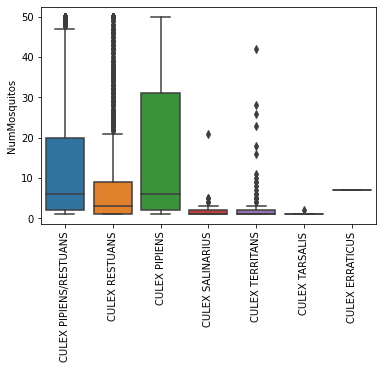

In [88]:
#Checking the number of mosqitos per species using boxplots
plt.figsize=(5,5)
g=sns.boxplot(x="Species", y="NumMosquitos", data=train)
g.set_xticklabels(g.get_xticklabels(), rotation=90,size=10)
g.set(xlabel=None)
g.xaxis.label.set_size(10)
g.yaxis.label.set_size(10)
plt.show()

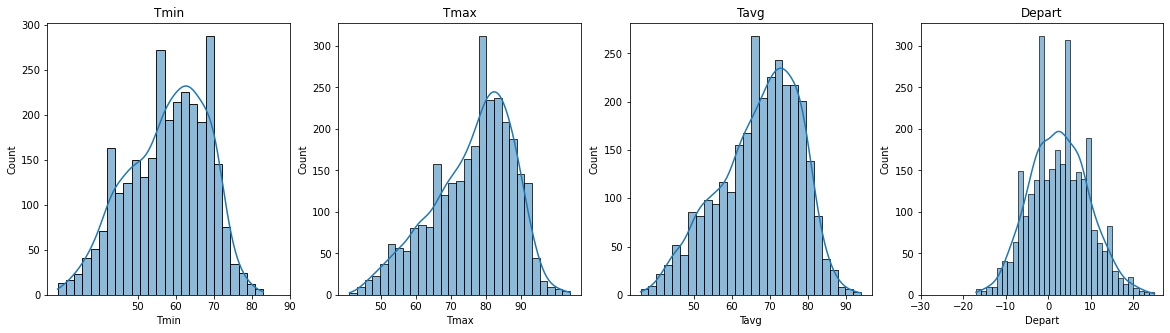

In [89]:
#Determining the effect of temperature. 
fig, ax = plt.subplots(1,4, figsize=(20,5))
sns.histplot(weather['Tmin'], ax=ax[0], kde = True)
ax[0].xaxis.set(ticks=np.arange(50,100,10))
ax[0].set_title('Tmin')


sns.histplot(weather['Tmax'], ax=ax[1], kde = True)
ax[1].xaxis.set(ticks=np.arange(50,100,10))
ax[1].set_title('Tmax')

sns.histplot(weather['Tavg'].apply(int), ax=ax[2], kde = True)
ax[2].xaxis.set(ticks=np.arange(50,100,10))
ax[2].set_title('Tavg')

sns.histplot(weather['Depart'].apply(int), ax=ax[3], kde = True)
ax[3].xaxis.set(ticks=np.arange(-30,30,10))
ax[3].set_title('Depart')

plt.show()

In [90]:
#Converting Sunrise into datetime
weather['Sunrise'] = weather['Sunrise'].map(lambda x: x[0:2]+':'+x[2:4])
weather['Sunrise']=pd.to_datetime(weather.Sunrise,format='%H:%M')-pd.to_datetime('1900-01-01 00:00:00')
weather.Sunrise

0      04:48:00
1      04:48:00
2      04:47:00
3      04:47:00
4      04:46:00
         ...   
2939   06:20:00
2940   06:22:00
2941   06:22:00
2942   06:23:00
2943   06:23:00
Name: Sunrise, Length: 2944, dtype: timedelta64[ns]

In [91]:
#Converting times into the next hour where needed if the base 100 number >=60. 
weather.Sunrise.replace('1860','1900',inplace=True)
weather.Sunrise.replace('1760','1800',inplace=True)
weather.Sunrise.replace('1660','1700',inplace=True)

In [92]:
#Converting Sunset into datetime
try:
    weather['Sunset'] = weather['Sunset'].map(lambda x: x[0:2]+':'+x[2:4])
    weather['Sunset']=pd.to_datetime(weather.Sunset,format='%H:%M')-pd.to_datetime('1900-01-01 00:00:00')
    weather.Sunset
except:
    pass

In [93]:
weather.Sunset.replace('1860','1900',inplace=True)
weather.Sunset.replace('1760','1800',inplace=True)
weather.Sunset.replace('1660','1700',inplace=True)

In [94]:
#Converting columns to int type
weather[['Tavg', 'Depart', 'WetBulb', 'Heat', 'Cool',
                   'WetBulb', 'Heat', 'Cool','Tavg'] ]=weather[['Tavg', 'Depart',
                   'WetBulb', 'Heat', 'Cool','WetBulb', 
                   'Heat', 'Cool','Tavg' ]].apply(pd.to_numeric)

In [95]:
#Converting Columns to float type
weather[['PrecipTotal','StnPressure', 'SeaLevel', 'AvgSpeed',
                   'PrecipTotal', 'StnPressure','SeaLevel', 'AvgSpeed'] ]=weather[[
                    'PrecipTotal','StnPressure', 'SeaLevel', 'AvgSpeed','PrecipTotal',
                    'StnPressure','SeaLevel', 'AvgSpeed' ]].apply(pd.to_numeric, downcast='float')

In [96]:
#Finding average of weather data between the two stations by date
weather = weather.drop("Station", axis = 1)
average = weather.groupby("Date").mean()
average.sort_values("Date", ascending = True)
average['Tavg'] = (average['Tmax'] + average['Tmin'])/2
tmp = average.pop("Tavg")
average.insert(2, "Tavg", tmp)

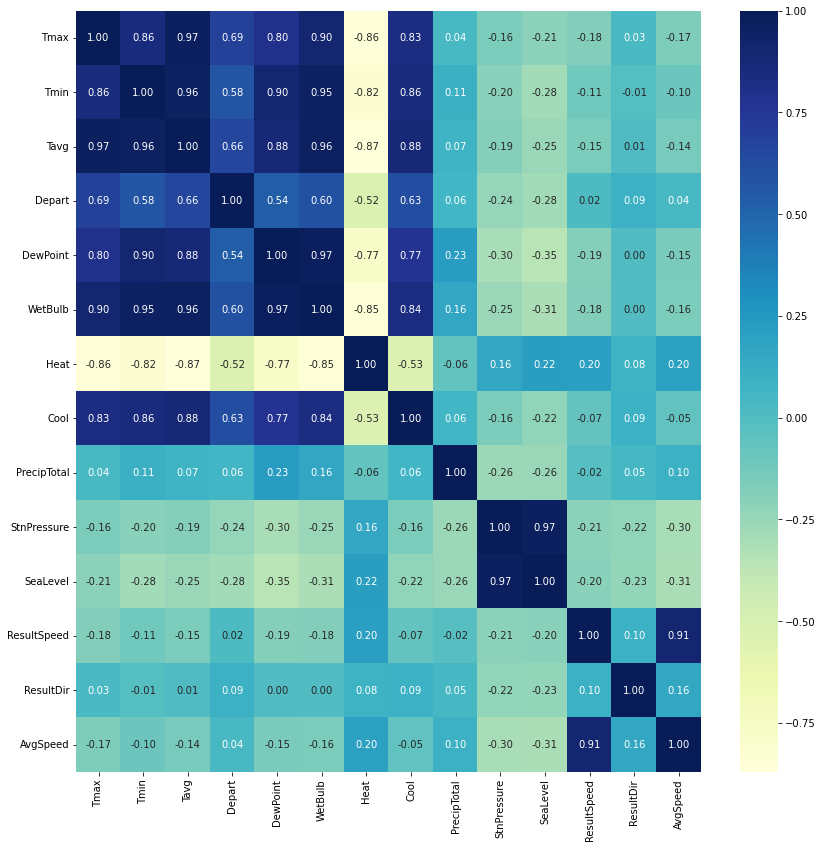

In [97]:
#Checking the correlation between columns
plt.subplots(figsize=(14,14))

ax = sns.heatmap(weather.corr(), annot=True,cmap="YlGnBu", annot_kws={'size':10}, fmt=".2f")

## Merging Train and Weather

In [98]:
#Merging Train and average (Weather)
merged = train.join(average, on='Date')

In [99]:
#Creating Day/Month/Year columns
def create_month(x):
    return x.split('-')[1]

def create_day(x):
    return x.split('-')[2]

def create_year(x): 
    return x.split('-')[0]

merged['month'] = merged.Date.apply(create_month).apply(pd.to_numeric)
merged['day'] = merged.Date.apply(create_day).apply(pd.to_numeric)
merged['year']=merged.Date.apply(create_year).apply(pd.to_numeric)

In [100]:
#Finding the streets with the highest virus concentration
x = merged.groupby(['year','Block','Street'])['WnvPresent'].sum()
y = merged.groupby(['year','Block','Street'])['Street'].count()

z = pd.concat([x,y], axis=1)
z['% Count'] = np.round(x/y,4)*100

z.index.rename(['Year','Block','StreetName'],inplace=True)
z.reset_index(inplace=True, )
z.set_index(['Block','StreetName'], inplace=True)
z.rename({'Stree':'Strt_Rec_Cnt'}, inplace=True)
z[z['% Count']>0].sort_values(by=['Year','% Count'], ascending=[True,False])

,,Year,WnvPresent,Street,% Count
Block,StreetName,,,,
40,E 130TH ST,2007,5,24,20.83
36,N PITTSBURGH AVE,2007,7,35,20.00
50,S UNION AVE,2007,6,30,20.00
65,N OAK PARK AVE,2007,6,31,19.35
72,N OKETO AVE,2007,7,39,17.95
...,...,...,...,...,...
10,E 67TH ST,2013,1,27,3.70
62,N MCCLELLAN AVE,2013,1,27,3.70
17,W ADDISON ST,2013,1,29,3.45


/Users/evanmeeks/opt/anaconda3/envs/sklearn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


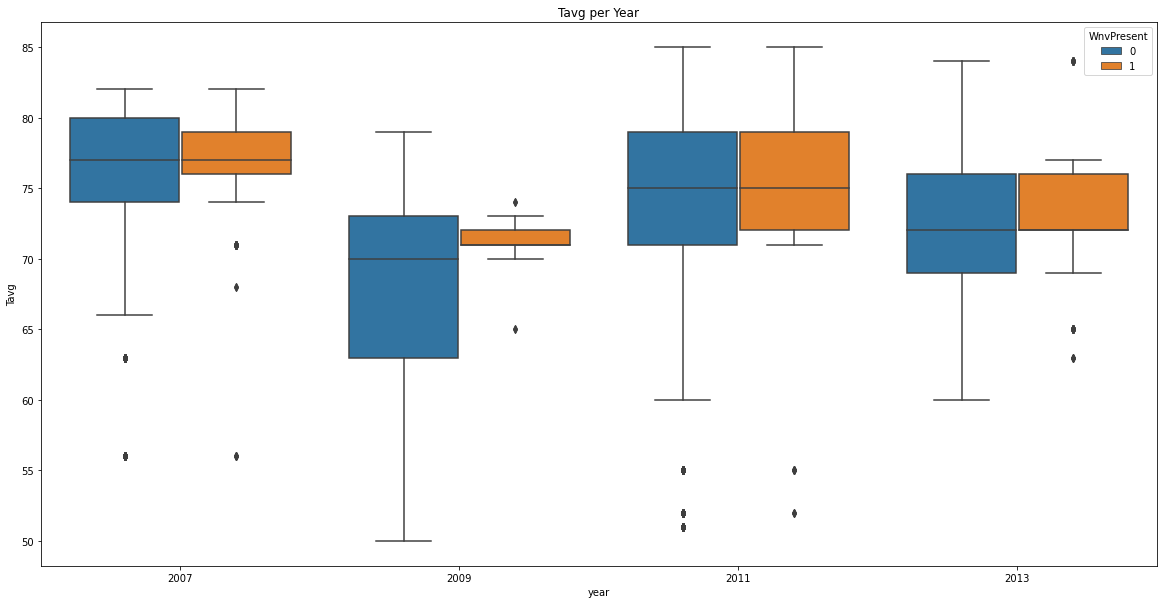

In [101]:
# A box plot of the Tavg each year shows that both warmer years and less volatile temperature differences
# during said year typically produced more WNV cases.
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.boxplot(merged['year'],merged['Tavg'].apply(int), hue = merged['WnvPresent'], ax=ax)
ax.set_title('Tavg per Year')
plt.show()

In [102]:
#Custom funtion to change months into their respective names, soley for readability.
def mkmonth(n):
    if n==5: month = 'May'
    elif n==6: month = 'June'
    elif n==7: month = 'July'
    elif n==8: month = 'Aug'
    elif n==9: month = 'Sep'   
    else: month = 'Oct'
    return(month)
merged["month"] =merged.month.apply(mkmonth)

In [103]:
merged.columns

Index(['Date', 'Species', 'Block', 'Street', 'Trap', 'Latitude', 'Longitude',
       'AddressAccuracy', 'NumMosquitos', 'WnvPresent', 'Tmax', 'Tmin', 'Tavg',
       'Depart', 'DewPoint', 'WetBulb', 'Heat', 'Cool', 'PrecipTotal',
       'StnPressure', 'SeaLevel', 'ResultSpeed', 'ResultDir', 'AvgSpeed',
       'month', 'day', 'year'],
      dtype='object')

In [126]:
#Getting dummies
dummies = pd.get_dummies(merged, columns = ['Species', 'month', 'year'])

In [127]:
#dropping species columns where virus never present, month where virus not present.
dummies=dummies.drop(['Species_CULEX TERRITANS','Species_CULEX SALINARIUS', 'Species_CULEX TARSALIS','Species_CULEX ERRATICUS','month_May','Date', 'Street','Trap', AddressAccuracy], axis=1)


In [133]:
X_train, X_test, y_train, y_test = train_test_split(dummies.drop(columns='WnvPresent'), 
                                                    dummies.WnvPresent, test_size=0.3, 
                                                    random_state=47)

In [134]:
#The following 'Weight of Evidence' and 'Information Value' techniques were copied from:
#https://sundarstyles89.medium.com/weight-of-evidence-and-information-value-using-python-6f05072e83eb#:~:text=Weight%20of%20evidence%20(WOE)%20and,the%20logistic%20regression%20modeling%20technique

max_bin = 20
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv) 

In [136]:
#creating WOE/IV variables
final_iv, IV = data_vars(dummies, dummies.WnvPresent)
final_iv

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,Block,10.000000,33.000000,5282,266,0.050360,5016,0.949640,0.482759,0.503867,-0.042796,0.001783
1,Block,34.000000,98.000000,5224,285,0.054556,4939,0.945444,0.517241,0.496133,0.041666,0.001783
2,Latitude,41.644612,41.846283,5265,248,0.047104,5017,0.952896,0.450091,0.503968,-0.113063,0.011647
3,Latitude,41.852652,42.017430,5241,303,0.057813,4938,0.942187,0.549909,0.496032,0.103113,0.011647
4,Longitude,-87.930995,-87.694991,5295,328,0.061945,4967,0.938055,0.595281,0.498945,0.176538,0.037577
...,...,...,...,...,...,...,...,...,...,...,...,...
66,year_2009,1.000000,1.000000,2249,19,0.008448,2230,0.991552,0.034483,0.224008,-1.871222,0.396059
67,year_2011,0.000000,0.000000,8452,494,0.058448,7958,0.941552,0.896552,0.799397,0.114698,0.075484
68,year_2011,1.000000,1.000000,2054,57,0.027751,1997,0.972249,0.103448,0.200603,-0.662255,0.075484
69,year_2013,0.000000,0.000000,8114,312,0.038452,7802,0.961548,0.566243,0.783727,-0.325037,0.222046


In [155]:
#Filtering IV for significant values only, assigning "x" to be only those features
features = list(IV[(IV['IV'] >= 0.01) & (IV['IV'] <= 0.8)]['VAR_NAME'])
x = dummies[features]
x

,AvgSpeed,Cool,Depart,DewPoint,Heat,Latitude,Longitude,PrecipTotal,ResultSpeed,Species_CULEX PIPIENS,...,Tmin,WetBulb,month_Aug,month_July,month_June,month_Oct,year_2007,year_2009,year_2011,year_2013
0,6.95,10.5,11.5,58.5,0.0,41.954690,-87.800991,0.0,5.80,0,...,62.5,65.5,0,0,0,0,1,0,0,0
1,6.95,10.5,11.5,58.5,0.0,41.954690,-87.800991,0.0,5.80,0,...,62.5,65.5,0,0,0,0,1,0,0,0
2,6.95,10.5,11.5,58.5,0.0,41.994991,-87.769279,0.0,5.80,0,...,62.5,65.5,0,0,0,0,1,0,0,0
3,6.95,10.5,11.5,58.5,0.0,41.974089,-87.824812,0.0,5.80,0,...,62.5,65.5,0,0,0,0,1,0,0,0
4,6.95,10.5,11.5,58.5,0.0,41.974089,-87.824812,0.0,5.80,0,...,62.5,65.5,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10501,4.40,0.0,4.0,52.0,1.0,41.763733,-87.742302,0.0,3.95,0,...,52.5,58.0,0,0,0,0,0,0,0,1
10502,4.40,0.0,4.0,52.0,1.0,41.987280,-87.666066,0.0,3.95,0,...,52.5,58.0,0,0,0,0,0,0,0,1
10503,4.40,0.0,4.0,52.0,1.0,41.912563,-87.668055,0.0,3.95,0,...,52.5,58.0,0,0,0,0,0,0,0,1
10504,4.40,0.0,4.0,52.0,1.0,42.009876,-87.807277,0.0,3.95,0,...,52.5,58.0,0,0,0,0,0,0,0,1


In [156]:
#Printing the VIF value for each column.
for i in range(x.shape[1]):
    print(i, " ", variance_inflation_factor(x.values, i))

0   8.000749122962647
1   1583.8480495905728
2   21.044281122866977
3   87.9559028309912
4   357.3651234302612
5   2.012865282053979
6   2.034895816772308
7   1.750944273525776
8   7.202555334640148
9   1.2456747288683865
10   1.210055658824557
11   2839.6774711301746
12   17.121311070976184
13   207.76581352028165
14   7.948485028662323
15   8.806320760366232
16   3.1500915787870256
17   1.9205713188272946
18   454139.98891924816
19   268183.6624930426
20   244944.08334275882
21   285212.3460567162


In [144]:
#Creating a custom function that will remove data with a VIF score outside of a given range. 
#A VIF of 5 is normally considered to represent high multicollinearity.
def iterate_vif(df, vif_threshold=5, max_vif=6):
    count = 0
    while max_vif > vif_threshold:
        count += 1
        print("Iteration # "+str(count))
        vif = pd.DataFrame()
        vif["VIFactor"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif["features"] = df.columns
        
        if vif['VIFactor'].max() > vif_threshold:
            print('Removing %s with VIF of %f' % (vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], vif['VIFactor'].max()))
            df = df.drop(vif[vif['VIFactor'] == vif['VIFactor'].max()]['features'].values[0], axis=1)
            max_vif = vif['VIFactor'].max()
        else:
            print('Complete')
            return df, vif.sort_values('VIFactor')  

x2 = x._get_numeric_data()
final_df, final_vif = iterate_vif(x)

Iteration # 1
Removing year_2007 with VIF of 454139.988919
Iteration # 2
Removing Longitude with VIF of 508057.440877
Iteration # 3
Removing Tavg with VIF of 110655.706316
Iteration # 4
Removing WetBulb with VIF of 18637.608277
Iteration # 5
Removing Tmin with VIF of 1118.227216
Iteration # 6
Removing DewPoint with VIF of 393.092881
Iteration # 7
Removing AvgSpeed with VIF of 69.918797
Iteration # 8
Removing Cool with VIF of 48.454011
Iteration # 9
Removing Latitude with VIF of 21.001362
Iteration # 10
Removing ResultSpeed with VIF of 5.042163
Iteration # 11
Complete


## Data Modeling

In [162]:
#Setting the training set to be the processed dataset, constraining the test set to match
#those columns. 
X_train = final_df
X_test=X_test[X_train.columns]